# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

In [1]:
helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.07KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

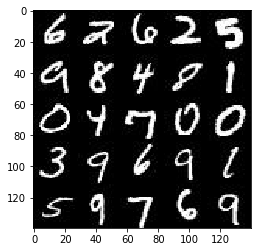

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

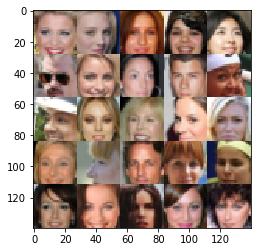

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,(None), name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        relu1 = tf.maximum(alpha * x1, x1)
        # Output layer is 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # Output layer is 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # Output layer is 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer - input (z_dim)
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # Out: 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # Out: 14x14x256
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        # Out: 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    gen_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(gen_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                    labels=tf.ones_like(d_logits_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print_every=10
    show_every=100
    
    
    image_width, image_height, image_channels = [dim for dim in data_shape[1:]]
    
    #Get the placeholders
    input_real, input_z, learning_r = model_inputs(image_width, image_height, image_channels, z_dim)
    
    #get the losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    #get the optimizers
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
            
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model   
                batch_images *= 2
                step += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,learning_r:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,learning_r:learning_rate})
                
                # Show output every show_every batches
                if step % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
               
                # At the end of print_every batches, get the losses and print them out
                train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                train_loss_g = g_loss.eval({input_z: batch_z})
                if step % print_every == 0:
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                    
        #Show a bigger output at the end         
        show_generator_output(sess, 15, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.
_Make sure the loss of the generator is lower than the loss of the discriminator or close to 0._  **This should probably be the other way around?!**


Epoch 1/2... Discriminator Loss: 0.4857... Generator Loss: 2.6677
Epoch 1/2... Discriminator Loss: 0.3538... Generator Loss: 4.5684
Epoch 1/2... Discriminator Loss: 4.3450... Generator Loss: 0.0858
Epoch 1/2... Discriminator Loss: 0.4792... Generator Loss: 8.3529
Epoch 1/2... Discriminator Loss: 0.6688... Generator Loss: 2.8863
Epoch 1/2... Discriminator Loss: 0.7817... Generator Loss: 1.6726
Epoch 1/2... Discriminator Loss: 0.9781... Generator Loss: 1.1975
Epoch 1/2... Discriminator Loss: 1.1374... Generator Loss: 1.6595
Epoch 1/2... Discriminator Loss: 1.2310... Generator Loss: 1.5066


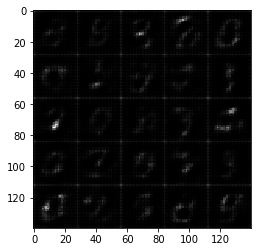

Epoch 1/2... Discriminator Loss: 1.2154... Generator Loss: 0.9524
Epoch 1/2... Discriminator Loss: 1.0662... Generator Loss: 1.1449
Epoch 1/2... Discriminator Loss: 1.3741... Generator Loss: 0.5731
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 0.7710
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 1.6107
Epoch 1/2... Discriminator Loss: 0.9951... Generator Loss: 1.1160
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 0.5568
Epoch 1/2... Discriminator Loss: 1.0593... Generator Loss: 1.8666
Epoch 1/2... Discriminator Loss: 0.9633... Generator Loss: 0.9862
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 2.0208


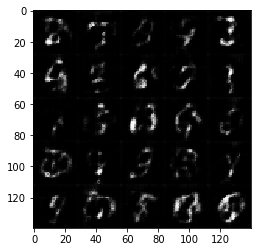

Epoch 1/2... Discriminator Loss: 0.9617... Generator Loss: 0.9674
Epoch 1/2... Discriminator Loss: 1.3254... Generator Loss: 2.6911
Epoch 1/2... Discriminator Loss: 0.9143... Generator Loss: 1.5468
Epoch 1/2... Discriminator Loss: 0.8941... Generator Loss: 1.5656
Epoch 1/2... Discriminator Loss: 0.9417... Generator Loss: 1.2671
Epoch 1/2... Discriminator Loss: 0.9096... Generator Loss: 1.0613
Epoch 1/2... Discriminator Loss: 1.8381... Generator Loss: 0.3128
Epoch 1/2... Discriminator Loss: 1.1823... Generator Loss: 0.7042
Epoch 1/2... Discriminator Loss: 1.1047... Generator Loss: 1.5514
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 2.3751


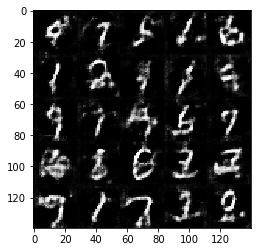

Epoch 1/2... Discriminator Loss: 0.9167... Generator Loss: 1.0260
Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 1.5124
Epoch 1/2... Discriminator Loss: 1.0030... Generator Loss: 1.0692
Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 0.5956
Epoch 1/2... Discriminator Loss: 0.9745... Generator Loss: 1.0039
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 0.8884
Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 0.9339... Generator Loss: 1.4511
Epoch 1/2... Discriminator Loss: 0.9564... Generator Loss: 0.9436
Epoch 1/2... Discriminator Loss: 1.0242... Generator Loss: 1.3146


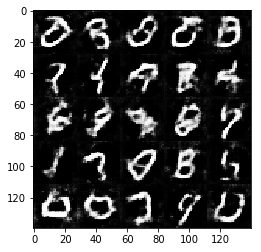

Epoch 1/2... Discriminator Loss: 0.9890... Generator Loss: 0.8876
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.1962
Epoch 1/2... Discriminator Loss: 1.0431... Generator Loss: 1.9064
Epoch 1/2... Discriminator Loss: 1.2064... Generator Loss: 0.6602
Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 0.8332
Epoch 1/2... Discriminator Loss: 0.9119... Generator Loss: 1.2964
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 1.9298
Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 0.6020
Epoch 2/2... Discriminator Loss: 1.0245... Generator Loss: 1.4655
Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 0.9156
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 1.8973
Epoch 2/2... Discriminator Loss: 1.0165... Generator Loss: 1.0007
Epoch 2/2... Discriminator Loss: 1.0747... Generator Loss: 1.3445
Epoch 2/2... Discriminator Loss: 0.9865... Generator Loss: 1.6417
Epoch 2/2... Discriminator Loss: 0.9170... Generator Loss: 1.2499
Epoch 2/2.

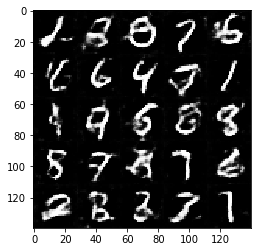

Epoch 2/2... Discriminator Loss: 1.1976... Generator Loss: 0.6482
Epoch 2/2... Discriminator Loss: 1.1511... Generator Loss: 0.8085
Epoch 2/2... Discriminator Loss: 1.0074... Generator Loss: 0.9731
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 1.3689
Epoch 2/2... Discriminator Loss: 0.8994... Generator Loss: 1.4332
Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 0.9143
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 2.3864
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 1.0802
Epoch 2/2... Discriminator Loss: 0.9830... Generator Loss: 0.9061
Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 0.5850


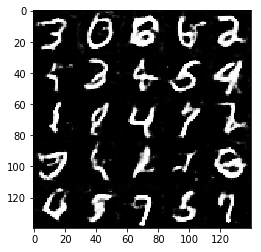

Epoch 2/2... Discriminator Loss: 0.8051... Generator Loss: 1.3620
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 1.1689
Epoch 2/2... Discriminator Loss: 0.8981... Generator Loss: 1.3444
Epoch 2/2... Discriminator Loss: 1.0051... Generator Loss: 1.9942
Epoch 2/2... Discriminator Loss: 1.0285... Generator Loss: 0.8436
Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 0.7881
Epoch 2/2... Discriminator Loss: 0.8540... Generator Loss: 1.1252
Epoch 2/2... Discriminator Loss: 2.3857... Generator Loss: 2.8281
Epoch 2/2... Discriminator Loss: 1.0436... Generator Loss: 0.9458
Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 1.4220


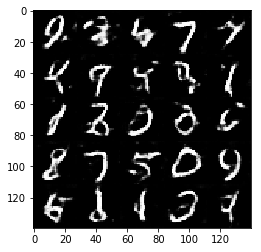

Epoch 2/2... Discriminator Loss: 0.9447... Generator Loss: 0.9516
Epoch 2/2... Discriminator Loss: 0.7746... Generator Loss: 1.2851
Epoch 2/2... Discriminator Loss: 0.8078... Generator Loss: 1.3059
Epoch 2/2... Discriminator Loss: 1.5610... Generator Loss: 3.2184
Epoch 2/2... Discriminator Loss: 0.8758... Generator Loss: 1.3448
Epoch 2/2... Discriminator Loss: 0.9093... Generator Loss: 1.0244
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 0.9059
Epoch 2/2... Discriminator Loss: 0.7246... Generator Loss: 1.5670
Epoch 2/2... Discriminator Loss: 1.5090... Generator Loss: 3.0229
Epoch 2/2... Discriminator Loss: 0.8118... Generator Loss: 1.1861


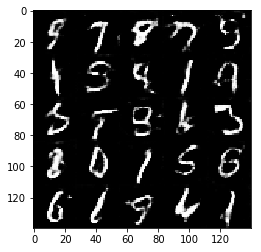

Epoch 2/2... Discriminator Loss: 2.4243... Generator Loss: 0.2065
Epoch 2/2... Discriminator Loss: 0.9263... Generator Loss: 0.9248
Epoch 2/2... Discriminator Loss: 0.7418... Generator Loss: 1.3800
Epoch 2/2... Discriminator Loss: 0.9098... Generator Loss: 1.0066
Epoch 2/2... Discriminator Loss: 0.9301... Generator Loss: 0.9614
Epoch 2/2... Discriminator Loss: 0.8655... Generator Loss: 1.1335
Epoch 2/2... Discriminator Loss: 1.0621... Generator Loss: 0.7879


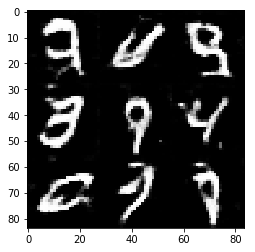

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6222... Generator Loss: 3.5165
Epoch 1/1... Discriminator Loss: 2.6177... Generator Loss: 9.6099
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.2217
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 1.6048
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 3.6283
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 2.9076
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 2.8980
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 5.8821
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.0412


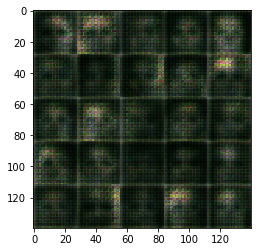

Epoch 1/1... Discriminator Loss: 1.7155... Generator Loss: 5.1849
Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 3.9023
Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 1.6177
Epoch 1/1... Discriminator Loss: 0.4642... Generator Loss: 2.5740
Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 2.5050
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 4.4599
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 2.3760
Epoch 1/1... Discriminator Loss: 1.8685... Generator Loss: 6.6878
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.8397... Generator Loss: 0.4196


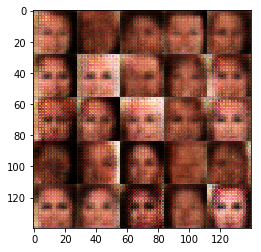

Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 1.7730
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 2.0729
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 7.0518
Epoch 1/1... Discriminator Loss: 1.9088... Generator Loss: 6.7037
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 7.1346
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 7.0414
Epoch 1/1... Discriminator Loss: 0.7370... Generator Loss: 1.1825
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.6409


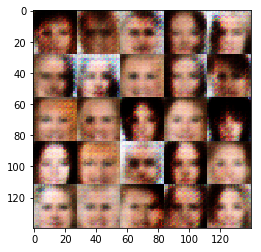

Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 8.8183
Epoch 1/1... Discriminator Loss: 0.3462... Generator Loss: 4.8937
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 0.4726... Generator Loss: 2.2130
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 1.9750
Epoch 1/1... Discriminator Loss: 0.4103... Generator Loss: 4.1971
Epoch 1/1... Discriminator Loss: 0.3790... Generator Loss: 3.3748
Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 5.7970


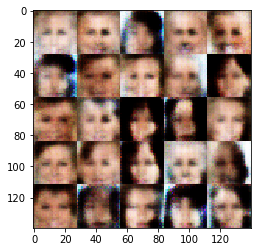

Epoch 1/1... Discriminator Loss: 0.3749... Generator Loss: 3.7448
Epoch 1/1... Discriminator Loss: 0.3579... Generator Loss: 4.1268
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 4.1908
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.5231
Epoch 1/1... Discriminator Loss: 0.5550... Generator Loss: 1.7648
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 1.5967
Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 1.7253
Epoch 1/1... Discriminator Loss: 0.4166... Generator Loss: 2.7158
Epoch 1/1... Discriminator Loss: 0.3678... Generator Loss: 3.6698
Epoch 1/1... Discriminator Loss: 0.4281... Generator Loss: 4.7910


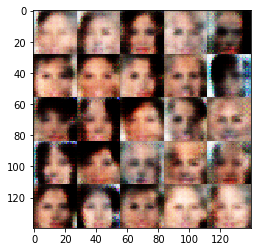

Epoch 1/1... Discriminator Loss: 0.3490... Generator Loss: 7.4096
Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 5.5350
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 0.5192... Generator Loss: 2.0084
Epoch 1/1... Discriminator Loss: 0.5654... Generator Loss: 3.0380
Epoch 1/1... Discriminator Loss: 0.4121... Generator Loss: 2.7341
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 2.6829
Epoch 1/1... Discriminator Loss: 2.5910... Generator Loss: 0.1948
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 4.3719


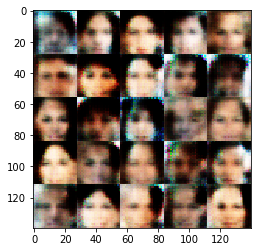

Epoch 1/1... Discriminator Loss: 0.3621... Generator Loss: 3.9870
Epoch 1/1... Discriminator Loss: 0.3846... Generator Loss: 3.6540
Epoch 1/1... Discriminator Loss: 0.3611... Generator Loss: 6.0455
Epoch 1/1... Discriminator Loss: 0.3441... Generator Loss: 5.1676
Epoch 1/1... Discriminator Loss: 0.3883... Generator Loss: 3.3590
Epoch 1/1... Discriminator Loss: 0.4178... Generator Loss: 2.7652
Epoch 1/1... Discriminator Loss: 0.3489... Generator Loss: 5.0960
Epoch 1/1... Discriminator Loss: 0.3769... Generator Loss: 4.7678
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 1.5552
Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 1.3950


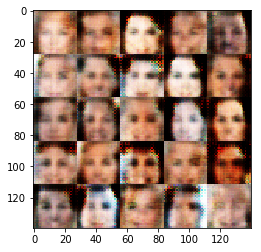

Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.3935
Epoch 1/1... Discriminator Loss: 0.7921... Generator Loss: 1.8754
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 1.3993
Epoch 1/1... Discriminator Loss: 2.2995... Generator Loss: 0.1878
Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 1.3109
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 0.5594... Generator Loss: 1.9324
Epoch 1/1... Discriminator Loss: 0.5410... Generator Loss: 1.9844
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 1.8557


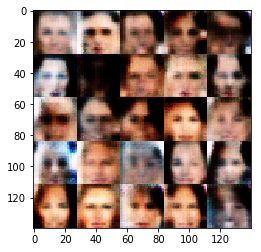

Epoch 1/1... Discriminator Loss: 0.3589... Generator Loss: 4.7327
Epoch 1/1... Discriminator Loss: 0.4421... Generator Loss: 2.8406
Epoch 1/1... Discriminator Loss: 0.3835... Generator Loss: 5.2769
Epoch 1/1... Discriminator Loss: 0.4689... Generator Loss: 2.2851
Epoch 1/1... Discriminator Loss: 0.4030... Generator Loss: 3.8134
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 2.0163
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.4784
Epoch 1/1... Discriminator Loss: 0.5136... Generator Loss: 2.0932
Epoch 1/1... Discriminator Loss: 0.5854... Generator Loss: 1.6382
Epoch 1/1... Discriminator Loss: 3.1503... Generator Loss: 0.0883


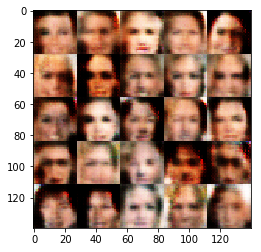

Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.4061
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 1.9461
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 4.2238
Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 6.2138
Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 3.6244
Epoch 1/1... Discriminator Loss: 2.2011... Generator Loss: 6.1295
Epoch 1/1... Discriminator Loss: 0.4964... Generator Loss: 2.3512
Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 2.4110


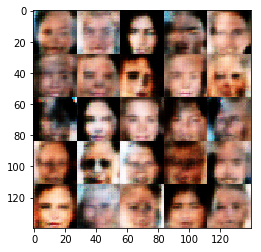

Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 7.0177
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 1.3477
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 5.1600
Epoch 1/1... Discriminator Loss: 0.3425... Generator Loss: 6.3998
Epoch 1/1... Discriminator Loss: 0.3733... Generator Loss: 4.4940
Epoch 1/1... Discriminator Loss: 0.4284... Generator Loss: 2.8309
Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 3.4969
Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 6.1312
Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 5.9795
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 1.0016


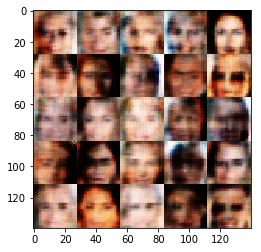

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.3296
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 1.6230
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.5615
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 2.1334
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 1.8464


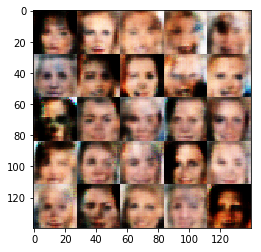

Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 3.4293
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 2.1319
Epoch 1/1... Discriminator Loss: 0.5533... Generator Loss: 1.8446
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 2.2574
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 2.2521
Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 3.6750
Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 3.3306
Epoch 1/1... Discriminator Loss: 0.3980... Generator Loss: 3.1841
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 5.0693


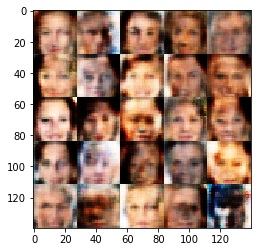

Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 1.3735
Epoch 1/1... Discriminator Loss: 0.5165... Generator Loss: 4.4702
Epoch 1/1... Discriminator Loss: 0.3592... Generator Loss: 6.9926
Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 1.4802
Epoch 1/1... Discriminator Loss: 0.7734... Generator Loss: 1.7046
Epoch 1/1... Discriminator Loss: 0.8327... Generator Loss: 5.8195
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 3.4891... Generator Loss: 4.7858
Epoch 1/1... Discriminator Loss: 0.7754... Generator Loss: 1.5798


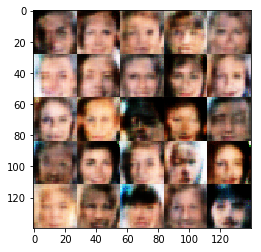

Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.2781
Epoch 1/1... Discriminator Loss: 0.4370... Generator Loss: 3.6604
Epoch 1/1... Discriminator Loss: 0.3963... Generator Loss: 3.9491
Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 2.8530
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 0.4035... Generator Loss: 3.4503
Epoch 1/1... Discriminator Loss: 0.4190... Generator Loss: 2.7934
Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 3.5325
Epoch 1/1... Discriminator Loss: 0.3609... Generator Loss: 4.2611
Epoch 1/1... Discriminator Loss: 0.3552... Generator Loss: 4.6479


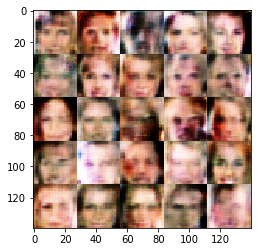

Epoch 1/1... Discriminator Loss: 0.3757... Generator Loss: 3.7826
Epoch 1/1... Discriminator Loss: 0.3524... Generator Loss: 5.6721
Epoch 1/1... Discriminator Loss: 2.0163... Generator Loss: 4.3576
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 1.8675
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 1.4427
Epoch 1/1... Discriminator Loss: 0.4294... Generator Loss: 2.7786
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 3.0214
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.7807


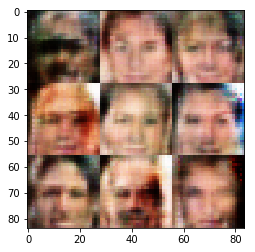

In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.